In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy.stats import spearmanr, kstest, norm, chi2_contingency
from sklearn.preprocessing import StandardScaler

##Cargado de datos

In [ ]:
df_url='https://docs.google.com/spreadsheets/d/1NJiaIRABEh1mJrqzP6bAYBkhBruBwUUzplHdXViv9-g/export?format=csv'
df=pd.read_csv(df_url)

##Funciones

In [ ]:
def Summary(data, sheet):
    print(f"Hoja: {sheet}")

    # Crear la tabla de resumen
    resumen = {
        "Cantidad de filas": data.shape[0],
        "Cantidad de columnas": data.shape[1],
        "Datos faltantes": data.isnull().sum().sum(),
        "Filas duplicadas": data.duplicated().sum()
    }

    # Convertir el resumen en un DataFrame
    ResumenHoja = pd.DataFrame(resumen, index=["Resumen"])
    print("\nResumen:")
    display(ResumenHoja)

    print("\nEncabezado:")
    display(data.head())

##Analisis exploratorio de datos

In [ ]:
Summary(df,'Datos pacientes')

Hoja: Datos pacientes

Resumen:


,Cantidad de filas,Cantidad de columnas,Datos faltantes,Filas duplicadas
Resumen,212691,17,0,0



Encabezado:


,Patient_ID,Age,Gender,Country,Ethnicity,Family_History,Radiation_Exposure,Iodine_Deficiency,Smoking,Obesity,Diabetes,TSH_Level,T3_Level,T4_Level,Nodule_Size,Thyroid_Cancer_Risk,Diagnosis
0,1,66,Male,Russia,Caucasian,No,Yes,No,No,No,No,9.37,1.67,6.16,1.08,Low,Benign
1,2,29,Male,Germany,Hispanic,No,Yes,No,No,No,No,1.83,1.73,10.54,4.05,Low,Benign
2,3,86,Male,Nigeria,Caucasian,No,No,No,No,No,No,6.26,2.59,10.57,4.61,Low,Benign
3,4,75,Female,India,Asian,No,No,No,No,No,No,4.10,2.62,11.04,2.46,Medium,Benign
4,5,35,Female,Germany,African,Yes,Yes,No,No,No,No,9.10,2.11,10.71,2.11,High,Benign


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 212691 entries, 0 to 212690
Data columns (total 17 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   Patient_ID           212691 non-null  int64  
 1   Age                  212691 non-null  int64  
 2   Gender               212691 non-null  object 
 3   Country              212691 non-null  object 
 4   Ethnicity            212691 non-null  object 
 5   Family_History       212691 non-null  object 
 6   Radiation_Exposure   212691 non-null  object 
 7   Iodine_Deficiency    212691 non-null  object 
 8   Smoking              212691 non-null  object 
 9   Obesity              212691 non-null  object 
 10  Diabetes             212691 non-null  object 
 11  TSH_Level            212691 non-null  float64
 12  T3_Level             212691 non-null  float64
 13  T4_Level             212691 non-null  float64
 14  Nodule_Size          212691 non-null  float64
 15  Thyroid_Cancer_Ri

In [ ]:
df.describe()

,Patient_ID,Age,TSH_Level,T3_Level,T4_Level,Nodule_Size
count,212691.00000,212691.000000,212691.000000,212691.000000,212691.000000,212691.000000
mean,106346.00000,51.918497,5.045102,2.001727,8.246204,2.503403
std,61398.74739,21.632815,2.860264,0.866248,2.164188,1.444631
min,1.00000,15.000000,0.100000,0.500000,4.500000,0.000000
25%,53173.50000,33.000000,2.570000,1.250000,6.370000,1.250000
50%,106346.00000,52.000000,5.040000,2.000000,8.240000,2.510000
75%,159518.50000,71.000000,7.520000,2.750000,10.120000,3.760000
max,212691.00000,89.000000,10.000000,3.500000,12.000000,5.000000


se realiza una tabla de frecuencias y un grafico de barras para la variable respuesta

In [ ]:
df.Thyroid_Cancer_Risk.value_counts()

,count
Thyroid_Cancer_Risk,
Low,108388
Medium,72400
High,31903


In [ ]:
sns.set_style("whitegrid")

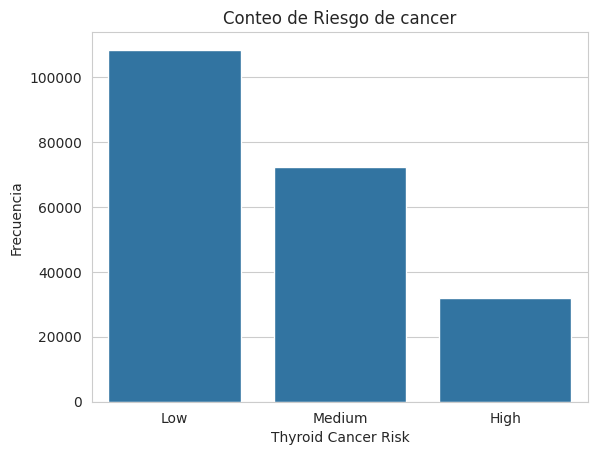

In [ ]:
plt.title('Conteo de Riesgo de cancer')
sns.countplot(x=df.Thyroid_Cancer_Risk)
plt.xlabel('Thyroid Cancer Risk')
plt.ylabel('Frecuencia')
plt.show()

podemos observar que tenemos un dataset desbalanceado, debemos tomar en cuenta esto antes de realizar cualquier algoritmo y balancear el dataset

seleccionamos las variables que estan correlacionadas con la variable respuesta usando el coeficiente de correlacion de spearman. debido a que estamos trabajando con una variable ordinal de 3 categorias

In [ ]:
scaler = StandardScaler()
scaler_params = {}
significant_columns = ['Thyroid_Cancer_Risk']
category_columns=['Gender', 'Country','Ethnicity', 'Family_History','Radiation_Exposure','Iodine_Deficiency','Smoking','Obesity','Diabetes', 'Diagnosis']
num_columns=[col for col in df.columns if col not in category_columns + ['Thyroid_Cancer_Risk']]
for column in df.columns:
  if column=='Thyroid_Cancer_Risk':
    continue
  if column in num_columns:
    D, p_value = kstest(df[column], norm.cdf, args=(df[column].mean(), df[column].std()))
    if p_value < 0.05:
      scaler.fit(df[column].values.reshape(-1, 1))
      scaler_params[column] = (scaler.mean_, scaler.scale_)
      df[column] = scaler.transform(df[column].values.reshape(-1, 1))
    corr, p_value = spearmanr(df[column], df['Thyroid_Cancer_Risk'])
  elif column in category_columns:
    contingency_table = pd.crosstab(df[column], df['Thyroid_Cancer_Risk'])
    _, p_value, _, _ = chi2_contingency(contingency_table)
  if p_value < 0.05:
    significant_columns.append(column)

df_significant = df[significant_columns]
for column, (mean, scale) in scaler_params.items():
    if column in df_significant.columns and column in num_columns:
        df_significant[column] = df_significant[column] * scale + mean

In [ ]:
print("\nDataFrame con las columnas significativas y revertidas a su escala original:")
df = df_significant
df.head()


DataFrame con las columnas significativas y revertidas a su escala original:


,Thyroid_Cancer_Risk,Country,Ethnicity,Family_History,Radiation_Exposure,Iodine_Deficiency,Diagnosis
0,Low,Russia,Caucasian,No,Yes,No,Benign
1,Low,Germany,Hispanic,No,Yes,No,Benign
2,Low,Nigeria,Caucasian,No,No,No,Benign
3,Medium,India,Asian,No,No,No,Benign
4,High,Germany,African,Yes,Yes,No,Benign


debemos verificar si existe multicolinealidad entre las variables

In [ ]:
X_mul = df.drop(columns=['Thyroid_Cancer_Risk'])
y_mul = df['Thyroid_Cancer_Risk']

In [ ]:
X_encoded = pd.get_dummies(X_mul, drop_first=True)

In [ ]:
vif_data = pd.DataFrame()
vif_data["feature"] = X_encoded.columns
vif_data["VIF"] = [variance_inflation_factor(X_encoded.values, i)
                   for i in range(X_encoded.shape[1])]
print(vif_data.sort_values(by='VIF', ascending=False))

                     feature       VIF
8                Country_USA  0.000110
1            Country_Germany  0.000110
7                 Country_UK  0.000110
6        Country_South Korea  0.000083
3              Country_Japan  0.000075
5             Country_Russia  0.000063
12  Ethnicity_Middle Eastern  0.000062
11        Ethnicity_Hispanic  0.000047
4            Country_Nigeria  0.000047
0              Country_China  0.000047
2              Country_India  0.000040
14    Radiation_Exposure_Yes  0.000037
9            Ethnicity_Asian  0.000035
10       Ethnicity_Caucasian  0.000031
16       Diagnosis_Malignant  0.000028
15     Iodine_Deficiency_Yes  0.000025
13        Family_History_Yes  0.000022


# Evaluacion del dataset mediante regresion logistica

se realizara una evaluacion del dataset reducido para saber si se le puede aplicar machine learning, pero se debe tomar en cuenta que el dataset esta desbalanceado, por lo que se realizara una pequeña comparacion entre el balanceado y el no balanceado para ver si los resultados cambian significativamente

In [ ]:
X = df.drop('Thyroid_Cancer_Risk', axis=1)
Y = df['Thyroid_Cancer_Risk']
binary_cols = ['Family_History', 'Radiation_Exposure', 'Iodine_Deficiency', 'Diagnosis']
nominal_cols = ['Country', 'Ethnicity']
for col in binary_cols:
    X[col] = X[col].map({'Yes': 1, 'No': 0, 'Positive': 1, 'Negative': 0, 'Benign': 0,'Malignant': 1})
X = pd.get_dummies(X, columns=nominal_cols, drop_first=True)
Y = Y.map({'Low': 0, 'Medium': 1, 'High': 2})
print(X.head())
print("Thyroid_Cancer_Risk")
print(Y.head())

   Family_History  Radiation_Exposure  Iodine_Deficiency  Diagnosis  \
0               0                   1                  0          0   
1               0                   1                  0          0   
2               0                   0                  0          0   
3               0                   0                  0          0   
4               1                   1                  0          0   

   Country_China  Country_Germany  Country_India  Country_Japan  \
0          False            False          False          False   
1          False             True          False          False   
2          False            False          False          False   
3          False            False           True          False   
4          False             True          False          False   

   Country_Nigeria  Country_Russia  Country_South Korea  Country_UK  \
0            False            True                False       False   
1            False          

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.4, random_state=42)
model = LogisticRegression()
model.fit(X_train, y_train)


LogisticRegression()

In [ ]:
y_pred = model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.5819081537900961
[[40640     0  2667]
 [27194     0  1753]
 [ 3956     0  8867]]
              precision    recall  f1-score   support

           0       0.57      0.94      0.71     43307
           1       0.00      0.00      0.00     28947
           2       0.67      0.69      0.68     12823

    accuracy                           0.58     85077
   macro avg       0.41      0.54      0.46     85077
weighted avg       0.39      0.58      0.46     85077



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
model_bal=LogisticRegression(class_weight='balanced')
model_bal.fit(X_train, y_train)

LogisticRegression(class_weight='balanced')

In [ ]:
y_pred_bal = model_bal.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred_bal))
print(confusion_matrix(y_test, y_pred_bal))
print(classification_report(y_test, y_pred_bal))

Accuracy: 0.5205872327421042
[[19957 19890  3460]
 [13446 13193  2308]
 [ 1030   653 11140]]
              precision    recall  f1-score   support

           0       0.58      0.46      0.51     43307
           1       0.39      0.46      0.42     28947
           2       0.66      0.87      0.75     12823

    accuracy                           0.52     85077
   macro avg       0.54      0.60      0.56     85077
weighted avg       0.53      0.52      0.52     85077

